# Exploring Gender Biases in Word2Vec 

This notebook processes the data from the Gutenburg and Wikipedia datasets. Then, it trains the words agains Genism's word2Vec model, a custom skip-gram based word2vec model and our debiasing solutions. 

To measure biases that are hidden within these embeddings created by the models, we explore the direct bias, indirect bias, and the WEAT metric for comparision. 

In [128]:
#library imports
import string
import numpy as np
from numpy.linalg import norm
import json
import tempfile
from sklearn.decomposition import PCA
import torch
from torchtext.data.utils import get_tokenizer

#configure paths
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\nn_webserver")

#gutenberg data import
from gutenberg.gutenberg_data import get_urls, read_data_from_urls

#models import
from gensim.models import Word2Vec
from custom_word2vec import Custom_Word2Vec
import pickle

#plots
import matplotlib.pyplot as plt 

## 1 - Data Preprocessing

In [2]:
def create_tokens(data):
    """
    creates tokenized list with puncuation and digits removed and lowercase words 

    :param data: list of strings
    :return: a list of tokens 
    """ 
    tokens = []
    for sentance in data:
        sentance = sentance.translate(str.maketrans('', '', string.punctuation)) #remove punctuations
        sentance = sentance.translate(str.maketrans('', '', string.digits)) #remove digits
        tokenizer = get_tokenizer("basic_english", language="en") #remove unessasary characters, splits into spaces
        tokens.append(tokenizer(sentance))
  
    return tokens
  

**Gutenburg Dataset**

In [3]:
# Gutenburg
train_urls = get_urls('train')
train_data_g = read_data_from_urls(train_urls)
train_data_g=str(train_data_g).split('.')

rough_guten = create_tokens(train_data_g)

sentences_gutenburg = []
for sentence in rough_guten:
    new_sentence = []
    for word in sentence:
        if 'rn' in word:
            temp = word.replace('rn', ' ')
            while temp and temp[0] == ' ':
                temp = temp.replace(' ', '')
            while temp and '  ' in temp:
                temp = temp.replace('  ', '')
            if ' ' in temp:
                temp = temp.split(' ')
                for word_thing in temp:
                    new_sentence.append(word_thing)
            else:
                new_sentence.append(temp)
        else:
            new_sentence.append(word)
    sentences_gutenburg.append(new_sentence)

**Wikipedia Dataset**

In [ ]:
#Wikipedia
f = open('wikipedia-en-1000.json')
train_data_w = json.load(f)
train_data_w =str(train_data_w[0]).split('.')

sentences_wikipedia = create_tokens(train_data_w)
print(len(sentences_wikipedia))

159


## 2 - Genism Word2Vec

Using: Skip-gram training algorithm. 

Hyperparameters:
- min_freq: choosing the top N most frequent words - for easier training, weed out words that are irrelevant to us 
- size: embedding size. We use 300 as per Bolukbasi et al.
- window: the window used for looking at context and center words when traing the embeddings 

In [110]:
#hyperparameters
min_freq = 50
size = 300
window = 5
epochs = 11

**Gutenburg Genism Model**

In [111]:
model_g = Word2Vec(min_count=min_freq, vector_size=size, window=window, sg=1) #sg=1 is the skip-gram training algorithm
model_g.init_weights()
model_g.build_vocab(sentences_gutenburg) 
model_g.train(sentences_gutenburg, total_examples=model_g.corpus_count, epochs=epochs)

model_g.save("models/model_g")


**Wikipedia Genism Model**

In [ ]:
model_w = Word2Vec(min_count=min_freq, vector_size=size, window=window, sg=1) #sg=1 is the skip-gram training algorithm
model_w.init_weights()
model_w.build_vocab(sentences_wikipedia) 
model_w.train(sentences_wikipedia, total_examples=model_g.corpus_count, epochs=epochs)

model_w.save("models/model_w")

Now, save the embeddings to use in debiasing. 

In [112]:
with open('embeddings/gutenberg_embeddings.txt', 'w') as f:
    for idx, key in enumerate(list(model_g.wv.index_to_key)):
        embedding = ' '.join(str(v) for v in model_g.wv.get_vector(key))
        f.write(key + " " + embedding+"\n")

In [ ]:
with open('embeddings/wikipedia_embeddings.txt', 'w') as f:
    for idx, key in enumerate(list(model_w.wv.index_to_key)):
        embedding = ' '.join(str(v) for v in model_w.wv.get_vector(key))
        f.write(key + " " + embedding+"\n")

## 3 - Custom Word2Vec 

Using the same hyperparameters as Genism, train our own word2vec model (withought debiasing) on the data. 

In [10]:
# hyperparameters
embedding_dim=300
LR=0.01
window_size=2
EPOCHS=5
min_freq = 1000

**Gutenburg Custom Model**

In [ ]:
model_g_custom = Custom_Word2Vec(sentences_gutenburg, embedding_dim, LR, window_size, EPOCHS, min_freq)
model_g_custom.train()

#store in Jupiter Notebook to reuse via (%store -r model_g_custom)
%store model_g_custom

Generating Skip Grams...
...(0.7419min)
Training. Curr Time = 09:04:11 , Estimated Finish Time = 18:09:22
Epoch: 1, Training Loss: 6551374.260236576  (78.5356min)
Epoch: 2, Training Loss: 6447569.940075085  (78.2289min)
Epoch: 3, Training Loss: 6435655.812316194  (78.0902min)
Epoch: 4, Training Loss: 6432436.643278345  (78.0330min)


**Wikipedia Custom Model**

In [ ]:
model_w_custom = Custom_Word2Vec(sentences_wikipedia, embedding_dim, LR, window_size, EPOCHS, min_freq)
model_w_custom.train()

#store in Jupiter Notebook to reuse via (%store -r model_w_custom)
%store model_w_custom

Now, save the embeddings to use in debiasing.

In [ ]:
with open('embeddings/gutenburg_custom_embeddings.txt', 'w') as f:
    for word in model_g_custom.corpus_vocab:
        embedding = ' '.join(model_g_custom.embedding(word))
        f.write(word + " " + embedding +"\n")

In [ ]:
with open('embeddings/wikipedia_custom_embeddings.txt', 'w') as f:
    for word in model_w_custom.corpus_vocab:
        embedding = ' '.join(model_w_custom.embedding(word))
        f.write(word + " " + embedding +"\n")

## 4 - Measuring Bias

### 4.0 - Define Helper functions

Define some useful helper functions to use in the measurement techniques

In [113]:
def get_vocab(model, model_type, vocab):
    '''
    returns the vocabulary of the model
    '''
    if model_type == 'genism' or model_type == 'wiki':
        return model.wv.key_to_index
    elif model_type == 'custom':
        return model.corpus_vocab
    elif model_type == 'debias':
        return vocab
    else:
        print("Model type is wrong")
        return []

def check_w_embedding(word_lists, model, printRemoved, model_type, vocab={}):
    '''
    checks if the embedding exists for the given word, and if not deletes it from the lists. 
    if printRemoved = true, it also declares the words that were not in the model embeddings. 
    '''
    new_w_lists = []
    
    for word_list in word_lists:
        new_w_l = []
        for w in word_list: 
            if w in get_vocab(model, model_type, vocab):
                new_w_l.append(w)
            else:
                if printRemoved:
                    print ("Word", w, " is not in the model")
        
        if (len(new_w_l)!=0):
            new_w_lists.append(new_w_l)
    
    return new_w_lists

def w_vec(word, model, model_type, vocab):
    '''
    returns the word embedding of the input word
    '''
    if model_type == 'genism' or model_type == 'wiki':
        return model.wv[word]
    elif model_type == 'custom':
        return model.embedding(word)
    elif model_type == 'debias':
        return vocab[word]
    else:
        print("Model type is wrong")
        return []

def cos_sim(a,b):
    '''
    returns the cosine similarity between 2 word embeddings 
    '''
    return np.dot(a, b)/(norm(a)*norm(b))

As well, for the debiased embeddings, we need a way to retrieve the dat from the embedding text file. Create a function to do so.

In [114]:
def read_debiased_embeddings(file):
    vocab = {}
    with open(file, 'r') as f:
        for line in f:
            key, embedding = line.split(' ', 1)#split by first space
            emb_vec= list(map(float, embedding.split(' ')[:-1])) #convert embedding to int, remove new line  
            vocab[key] = np.array(emb_vec)
    return vocab 

### 4.1 - Construct the g subspace
First, define gendered words and pairs ground truth (taken from Bolukbasi et al.) Using PCA, define the gendered subspace g, by taking the most prominent dimension. 

In [130]:
def filter_gender_pairs(gender_pairs):
    filtered_pairs=[]
    for pair in gender_pairs:
        if len(pair)==2:
            filtered_pairs.append(pair)
    return filtered_pairs

def gender_subspace_matrix(model, gender_pairs, model_type, vocab):
    '''
    create matrix of the gender space using gender pairs
        
    '''
    word_directions = []
    for word_pair in gender_pairs:
        if (len(word_pair) == 2):
            f_word = w_vec(word_pair[0], model, model_type, vocab)
            m_word = w_vec(word_pair[1], model, model_type, vocab)
            dif = f_word-m_word
            word_directions.append(dif)
        
        
    return np.array(word_directions)


def define_vector_g(model, model_type, gender_pairs, vocab={}):
    word_directions = gender_subspace_matrix(model, gender_pairs, model_type, vocab) 

    #PCA of word direction
    pca = PCA(n_components=len(gender_pairs))
    pca.fit(word_directions)
    
    ratios = pca.explained_variance_ratio_
    #print graph of PCA dimensions to determine how many dimensions should be kept
    print("PCA variance ratio:", ratios)
    print("PCA singular values:", pca.singular_values_)

    #use the 1 most prominent dimension
    pca = PCA(n_components=1)
    pca.fit(word_directions)
    g = pca.components_
    
    return g, ratios

def run_gender_subspace_calcs(model, model_type, txtfiles):
    variance_ratios = []
    #genism model
    print ("---------Original-------------")
    gender_pairs_new = filter_gender_pairs(check_w_embedding(gender_pairs, model, False, model_type))
    print ("Gender Pairs: ", gender_pairs_new)
    g, pca_ratios = define_vector_g(model, model_type, gender_pairs_new)
    variance_ratios.append(pca_ratios)

    #2016 debiasing 
    print ("---------2016debias-------------")
    

    #2018 debiasing
    print ("---------2018debias-------------")
    vocab2018 = read_debiased_embeddings(txtfiles[0])
    gender_pairs_2018 = filter_gender_pairs(check_w_embedding(gender_pairs, model, False, 'debias', vocab2018))
    print ("Gender Pairs: ", gender_pairs_2018)
    g_2018, pca_ratios_2018 = define_vector_g(model, 'debias', gender_pairs_2018, vocab2018)
    variance_ratios.append(pca_ratios_2018)

    #combined graph:
    labels = ['Original', '2018 Debiasing']
    colors = ['orange', 'blue']
    plot_significance(variance_ratios, labels, colors, model_type)
    
    return g, g_2018

def plot_significance(variance_ratios, labels, colors, model):
    width = 0.3
    for i in range(len(variance_ratios)):
        ratio = variance_ratios[i]
        r = np.arange(1, len(ratio)+1)
        plt.bar(r + width*i, ratio, color=colors[i], edgecolor='white', width=width, alpha=0.5)
        plt.xlabel("Matrix Variance Column")
        plt.ylabel("Variance")
    
    
    plt.title("Significance of each eigenvector for "+model+" models") 
    plt.legend(labels)
    plt.show()
        

#gender pairs
gender_pairs = [['she','he'],['her','his'],['woman','man'],['Mary','John'],['herself','himself'],['daughter','son'],['mother','father'],['gal','guy'],['girl','boy'],['female','male']]

**Gender Subspace for Gutenburg Models**

---------Original-------------
Gender Pairs:  [['she', 'he'], ['her', 'his'], ['woman', 'man'], ['herself', 'himself'], ['daughter', 'son'], ['mother', 'father'], ['girl', 'boy'], ['female', 'male']]
PCA variance ratio: [2.2873145e-01 2.1048002e-01 1.6368133e-01 1.5716054e-01 1.3005719e-01
 7.5725868e-02 3.4163605e-02 6.6469462e-15]
PCA singular values: [4.0653491e+00 3.8997819e+00 3.4390182e+00 3.3698196e+00 3.0655053e+00
 2.3391445e+00 1.5711467e+00 6.9302035e-07]
---------2016debias-------------
---------2018debias-------------
Gender Pairs:  [['she', 'he'], ['her', 'his'], ['woman', 'man'], ['herself', 'himself'], ['daughter', 'son'], ['mother', 'father'], ['gal', 'guy'], ['girl', 'boy'], ['female', 'male']]
PCA variance ratio: [2.16777197e-01 1.97392966e-01 1.56127963e-01 1.49379561e-01
 1.23078041e-01 7.28935139e-02 5.28054050e-02 3.15453540e-02
 1.41289443e-32]
PCA singular values: [4.07391790e+00 3.88750813e+00 3.45736969e+00 3.38182448e+00
 3.06969878e+00 2.36238087e+00 2.0106

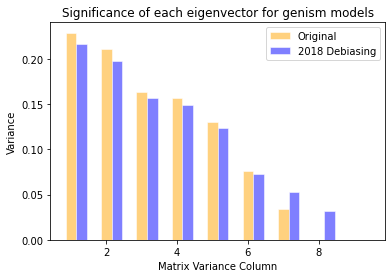

In [131]:
#load model
model_g = Word2Vec.load("models/model_g")

#calculate g subspace
g_gutenburg, g_gutenburg_2018 = run_gender_subspace_calcs(model_g, "genism", ["2018debias/2018debias_gutenberg_emb.txt"])

**Gender Subspace for Wikipedia Models**

In [94]:
#load model
model_w = Word2Vec.load("models/model_w")

#calculate g subspace
g_wiki, g_wiki_2018 = run_gender_subspace_calcs(model_w, "wiki", ["2018debias/2018debias_wiki_emb.txt"])

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_w.wv.vectors.npy'

### 4.2 - Direct Bias

To measure direct bias, we will be using the equation from Bolukbasi et al. shown below. 

<img src="img/Direct_Bias.png" style="width:300px;float:left;"/>

We will use the same gender neutral words that have been collected from the paper which is 
denoted by N. As well, we will utilize the paper’s gender directions (vector from one word to another) 
which were verified by crowdsourcing. The gender subspace g will be the unit vector g that captures the
gender directions, computed by principal components in the paper. Finally, we will consider c, which is the 
strictness of bias, as a hyperparameter in our experiment. 

In [132]:
def calculate_direct_metric(gendered_word_set, model, c, g, model_type, vocab={}):
    '''
    calculate the direct bias using Bolukbasi et al.'s equation
    '''
    cosine_add = 0
    for word in gendered_word_set:
        cosine_add += np.abs(cos_sim(w_vec(word, model, model_type, vocab),g[0]))**c
    
    return cosine_add/len(gendered_word_set)
    

c = 1 #hyperparameter

# Gendered word from Boulbalski et al. 
gendered_words = 'he, his, her, she, him, man, women, men, woman, spokesman, wife, himself, son, mother, father, chairman, daughter, husband, guy, girls, girl, boy, boys, brother, spokeswoman, female, sister, male, herself, brothers, dad, actress, mom, sons, girlfriend, daughters, lady, boyfriend, sisters, mothers, king, businessman, grandmother, grandfather, deer, ladies, uncle, males, congressman, grandson, bull, queen, businessmen, wives, widow, nephew, bride, females, aunt, prostate cancer, lesbian, chairwoman, fathers, moms, maiden, granddaughter, younger brother, lads, lion, gentleman, fraternity, bachelor, niece, bulls, husbands, prince, colt, salesman, hers, dude, beard, filly, princess, lesbians, councilman, actresses, gentlemen, stepfather, monks, ex girlfriend, lad, sperm, testosterone, nephews, maid, daddy, mare, fiance, fiancee, kings, dads, waitress, maternal, heroine, nieces, girlfriends, sir, stud, mistress, lions, estranged wife, womb, grandma, maternity, estrogen, ex boyfriend, widows, gelding, diva, teenage girls, nuns, czar, ovarian cancer, countrymen, teenage girl, penis, bloke, nun, brides, housewife, spokesmen, suitors, menopause, monastery, motherhood, brethren, stepmother, prostate, hostess, twin brother, schoolboy, brotherhood, fillies, stepson, congresswoman, uncles, witch, monk, viagra, paternity, suitor, sorority, macho, businesswoman, eldest son, gal, statesman, schoolgirl, fathered, goddess, hubby, stepdaughter, blokes, dudes, strongman, uterus, grandsons, studs, mama, godfather, hens, hen, mommy, estranged husband, elder brother, boyhood, baritone, grandmothers, grandpa, boyfriends, feminism, countryman, stallion, heiress, queens, witches, aunts, semen, fella, granddaughters, chap, widower, salesmen, convent, vagina, beau, beards, handyman, twin sister, maids, gals, housewives, horsemen, obstetrics, fatherhood, councilwoman, princes, matriarch, colts, ma, fraternities, pa, fellas, councilmen, dowry, barbershop, fraternal, ballerina'
gendered_words = gendered_words.split(", ")

**Direct Metric for Gutenburg Models**

In [133]:
#load models
model_g = Word2Vec.load("models/model_g")

#genism
gendered_word_set = check_w_embedding([gendered_words], model_g, False, 'genism')[0]
print("Direct metric gutenburg:", calculate_direct_metric(gendered_word_set, model_g, c, g_gutenburg, 'genism'))

#2016 debiasing 

#2018 debiasing
vocab2018 = read_debiased_embeddings('2018debias/2018debias_gutenberg_emb.txt')
gendered_word_set_2018 = check_w_embedding([gendered_words], model_g, False, 'debias', vocab2018)[0]
print("Direct metric gutenburg 2018 debias:", calculate_direct_metric(gendered_word_set_2018, model_g, c, g_gutenburg_2018, 'debias', vocab2018))


Direct metric gutenburg: 0.08597868991905432
Direct metric gutenburg 2018 debias: 0.08232383582820692


**Direct Metric for Wikipedia Models**

In [103]:
#load models
model_w =  Word2Vec.load("models/model_g")

#genism
gendered_word_set = check_w_embedding([gendered_words], model_w, False, 'genism')[0]
print("Direct metric wiki:", calculate_direct_metric(gendered_word_set, model_w, c, g_wiki, 'genism'))

#2016 debiasing 

#2018 debiasing
vocab2018 = read_debiased_embeddings('2018debias/2018debias_wiki_emb.txt')
gendered_word_set_2018 = check_w_embedding([gendered_words], model_w, False, 'debias', vocab2018)[0]
print("Direct metric wiki 2018 debias:", calculate_direct_metric(gendered_word_set_2018, model_w, c, g_wiki_2018, 'debias', vocab2018))

NameError: name 'g_wiki' is not defined

### 4.3 - Indirect Bias

To measure indirect bias, we will be using the equation from Bolukbasi et al. shown below.

<img src="img/Indirect_Bias.png" style="width:300px;float:left;"/>

$w_{\perp}$ is defined as $w_{\perp} = w - w_{g}$ where $w_{g}=(w*g)*g$ as mentioned in the paper. We will be using the g subspace calculated above. As for the word pairs, we will run a few experiments. The first will be the most extreme words in the softball-football direction as mentioned in the paper. 

In [194]:
def calculate_indirect_metric(g, w, v):
    wg = np.dot(np.dot(w,g[0]),g[0])
    vg = np.dot(np.dot(v,g[0]),g[0])
    w_norm_vec = w-wg
    v_norm_vec = v-vg
    w_norm = norm(w_norm_vec)
    v_norm = norm(v_norm_vec)
    
    return (np.dot(w,v) - np.dot(w_norm_vec,v_norm_vec)/(w_norm*v_norm))/np.dot(w,v)

def compare_indirect_metrics(words, c_word, model,g, model_type, vocab={}):
    metrics=[]
    for w in words:
        metrics.append(calculate_indirect_metric(g, w_vec(c_word,model, model_type, vocab), w_vec(w,model, model_type, vocab)))
    
    return metrics

def plot_indirect_metric(words, w, m, model, g_values, model_type, labels, txtfiles, colors):
    fig, ax = plt.subplots(1,1) 
    
    for i in range(len(labels)):
        b_vals_w = []
        b_vals_m = []
        #calculate indirect beta values
        if labels[i] == "Original": #first iteration
            b_vals_w = compare_indirect_metrics(words, w, model, g_values[i], model_type)
            b_vals_m = compare_indirect_metrics(words, m, model, g_values[i], model_type)
        else:
            vocab = read_debiased_embeddings(txtfiles[i-1])
            b_vals_w = compare_indirect_metrics(words, w, model, g_values[i], "debias", vocab)
            b_vals_m = compare_indirect_metrics(words, m, model, g_values[i], "debias", vocab)
            
    
        #plot
        ax.plot(range(1, len(words)+1), b_vals_w, marker='o', color = colors[i])
        ax.plot(range(1, len(words)+1), b_vals_m, '--', marker='o', color = colors[i])
        

    ax.set_xticks(range(1, len(words_w)+1))
    ax.set_xticklabels(words, rotation='horizontal', fontsize=10)
    plt.ylabel('β values')
    plt.xlabel('non-related words')
    plt.title('Indirect metrics for '+ model_type+ " models")
    
    legend_labels =[]
    for l in labels:
        legend_labels.append(w + " - "+ l)
        legend_labels.append(m + " - "+ l)
        
    ax.legend(legend_labels)
    plt.show()
    
#Experiment- recreate Bolukbasi et al.'s experiement but with words available in the datasetss
words_w= ['beauty', 'fashion', 'marriage', 'charm', 'nurse'] 
w = 'clean' 
words_m = ['paper', 'money', 'office', 'police', 'strength'] 
m = 'build'

**Indirect Metric for Gutenburg Models**

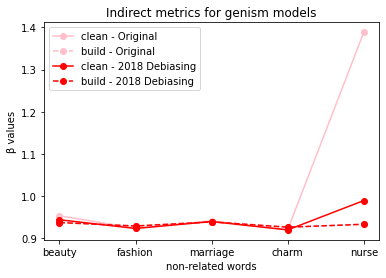

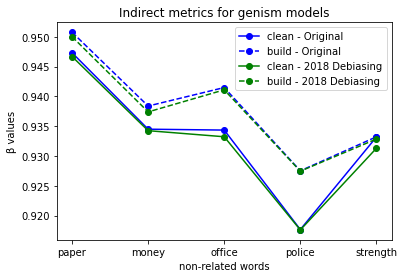

In [197]:
#load models
model_g = Word2Vec.load("models/model_g")

#check that all models contain the experiment words
words_w, words_m, [w, m] = check_w_embedding([words_w, words_m, [w, m]], model_g, True, 'genism')

#female correlated words
plot_indirect_metric(words_w, w, m, model_g, [g_gutenburg, g_gutenburg_2018], 'genism', ['Original', '2018 Debiasing'], ["2018debias/2018debias_gutenberg_emb.txt"], ["Pink", "Red"])

#male correlated words
plot_indirect_metric(words_m, w, m, model_g, [g_gutenburg, g_gutenburg_2018], 'genism', ['Original', '2018 Debiasing'], ["2018debias/2018debias_gutenberg_emb.txt"], ["Blue", "Green"])


**Indirect Metric for Wikipedia Models**

In [ ]:
#load models
model_g = Word2Vec.load("models/model_w")

#check that all models contain the experiment words
words_w, words_m, [w, m] = check_w_embedding([words_w, words_m, [w, m]], model_w, True, 'wiki')

#female correlated words
plot_indirect_metric(words_w, w, m, model_w, [g_wiki, g_wiki_2018], 'genism', ['Original', '2018 Debiasing'], ["2018debias/2018debias_gutenberg_emb.txt"], ["Pink", "Red"])

#male correlated words
plot_indirect_metric(words_m, w, m, model_w, [g_wiki, g_wiki_2018], 'genism', ['Original', '2018 Debiasing'], ["2018debias/2018debias_gutenberg_emb.txt"], ["Blue", "Green"])


### 4.4 - WEAT Metric

To measure WEAT, we used the formula defined in Caliskan et al., which is an additional direct bias measure. 

<img src="img/WEAT.png" style="width:300px;float:left;"/>

In [198]:
def s_word_A_B(w,A,B,model, model_type, vocab):
    mean_A_sum = 0
    mean_B_sum = 0
    w_v = w_vec(w,model, model_type, vocab)
    
    for a in A:
        a_vec = w_vec(a,model, model_type, vocab)
        mean_A_sum +=cos_sim(w_v,a_vec)
    
    for b in B:
        b_vec = w_vec(b,model, model_type, vocab)
        mean_B_sum +=cos_sim(w_v,b_vec)
        
    return mean_A_sum/len(A) - mean_B_sum/len(B)

def s_X_Y_A_B(X,Y,A,B,model, model_type, vocab={}):
    sum_X = 0
    sum_Y = 0
    
    for x in X:
        sum_X += s_word_A_B(x,A,B,model, model_type, vocab)
        
    for y in Y:
        sum_Y += s_word_A_B(y,A,B,model, model_type, vocab)
    
    return sum_X - sum_Y

Now, lets run experiments on the models <br>
A and B are the attribute word groups (8 words each), and X,Y are the target words

In [199]:
#Experiment 1 - work/family
A = ['tie', 'manage', 'work', 'paper', 'money', 'office', 'business', 'meeting']
B = ['home', 'parents', 'children', 'family', 'sister', 'marriage', 'charm', 'clean']
X = ['he', 'him']
Y = ['she', 'her'] 

#Experiment 2 - professions
A_2 = ['police', 'manage', 'business', 'lawyer', 'officer', 'science', 'build', 'fire']
B_2 = ['teacher', 'clean', 'social', 'hair', 'art', 'make', 'writer', 'library'] 


**WEAT Metric for Gutenburg Models**

In [204]:
#load models
model_g = Word2Vec.load("models/model_g")

print ("---------Genism-------------")
A_g,B_g,X_g,Y_g,A_2_g,B_2_g = check_w_embedding([A,B,X,Y, A_2,B_2], model_g, True, 'genism')
print ("WEAT Exp 1:", s_X_Y_A_B(X_g,Y_g,A_g,B_g,model_g, 'genism'))
print ("WEAT Exp 2:", s_X_Y_A_B(X_g,Y_g,A_2_g,B_2_g,model_g, 'genism'))

print ("---------2018 Debiasing-------------")
vocab2018 = read_debiased_embeddings("2018debias/2018debias_gutenberg_emb.txt")
A_g_2018,B_g_2018,X_g_2018,Y_g_2018,A_2_g_2018,B_2_g_2018 = check_w_embedding([A,B,X,Y, A_2,B_2], model_g, True, 'debias', vocab2018)
print ("WEAT Exp 1:", s_X_Y_A_B(X_g_2018,Y_g_2018,A_g_2018,B_g_2018,model_g, 'debias', vocab2018))
print ("WEAT Exp 2:", s_X_Y_A_B(X_g_2018,Y_g_2018,A_2_g_2018,B_2_g_2018,model_g, 'debias', vocab2018))


---------Genism-------------
WEAT Exp 1: 0.17949908575974405
WEAT Exp 2: 0.09589393716305494
---------2018 Debiasing-------------
WEAT Exp 1: 0.15221834486977004
WEAT Exp 2: 0.09102151140409755


**WEAT Metric for Wikipedia Models**

In [ ]:
#load models
model_w = Word2Vec.load("models/model_w")

print ("---------Genism-------------")
A_w,B_w,X_w,Y_w,A_2_w,B_2_w = check_w_embedding([A,B,X,Y,A_2,B_2], model_w, True, 'wiki')
print ("WEAT Exp 1:", s_X_Y_A_B(X_w,Y_w,A_w,B_w,model_w, 'wiki'))
print ("WEAT Exp 2:", s_X_Y_A_B(X_w,Y_w,A_2_w,B_2_w,model_w, 'wiki'))

print ("---------2018 Debiasing-------------")
vocab2018 = read_debiased_embeddings("2018debias/2018debias_gutenberg_emb.txt")
A_w_2018,B_w_2018,X_w_2018,Y_w_2018,A_2_w_2018,B_2_w_2018 = check_w_embedding([A,B,X,Y,A_2,B_2], model_w, True, 'debias', vocab2018)
print ("WEAT Exp 1:", s_X_Y_A_B(X_w_2018,Y_w_2018,A_w_2018,B_w,model_w_2018, 'debias', vocab2018))
print ("WEAT Exp 2:", s_X_Y_A_B(X_w_2018,Y_w_2018,A_2_w_2018,B_2_w_2018,model_w, 'debias', vocab2018))
